<a href="https://colab.research.google.com/github/heroza/Skin-Cancer-Diagnosis/blob/main/Skin_Cancer_Diagnosis_using_ISIC_2018_Dataset_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Data

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model, load_model

!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv') 
df_val = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv') 
num_classes = 7
#df_train

In [ ]:
#decode one hot label
df_train["Labels"] = (df_train.iloc[:, 1:]).idxmax(axis=1)
df_val["Labels"] = (df_val.iloc[:, 1:]).idxmax(axis=1)

#drop one-hot column
df_train = df_train.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
df_val = df_val.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

#make filepaths of the image
dir_train = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_Input/'
dir_val = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_Input/'
df_train['FilePaths'] = dir_train + df_train['image'] + '.jpg'
df_val['FilePaths'] = dir_val + df_val['image'] + '.jpg'

Label Distribution

[Text(0, 0, 'DF'),
 Text(0, 0, 'VASC'),
 Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV')]

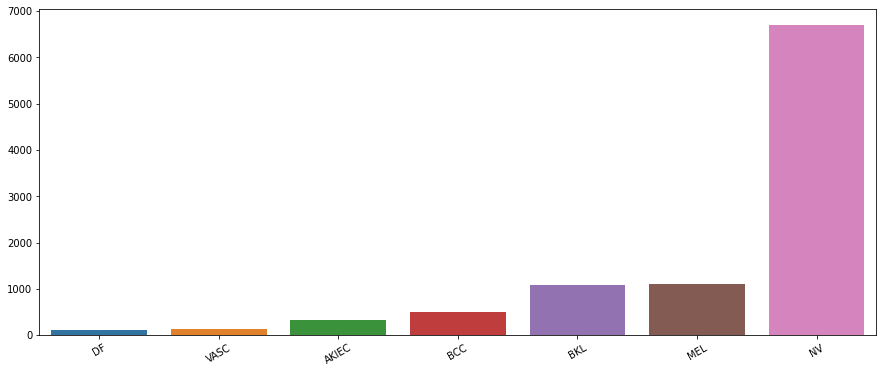

In [ ]:
# ordered count of rows per unique label
labels_count = df_train['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

In [ ]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df_train['Labels'].unique())
#for label in labels:
#    plot_images_per_label(df_train, label, 3, (12,9))

Drop duplicate images

In [ ]:
df_group = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_LesionGroupings.csv') 
df_train = df_train.set_index('image').join(df_group.set_index('image'))
df_train = df_train.drop_duplicates(subset=['lesion_id'])


Manual undersampling majority class

In [ ]:
df_train = df_train.drop(df_train[df_train['Labels'] == 'NV'].sample(frac=.3).index)

Prepare X,y

In [ ]:
# input image size
IMAGE_W = 224
IMAGE_H = 224
IMG_SIZE = (IMAGE_W,IMAGE_H)

In [ ]:
#TIME CONSUMING OPERATION
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
#X = []
#for img in df['FilePaths']:
    #img_arr = load_img(img, target_size=IMG_SIZE)
#    with load_img(img, target_size=IMG_SIZE) as img_arr:
#      X.append(img_to_array(img_arr))

#X = np.array(X)
df_train['image_px'] = df_train['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))
df_val['image_px'] = df_val['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))


In [ ]:
X_train = np.asarray(df_train['image_px'].tolist())
X_val = np.asarray(df_val['image_px'].tolist())
print(np.array(X_train).shape)
print(np.array(X_val).shape)

(8003, 224, 224, 3)
(193, 224, 224, 3)


In [ ]:
#Normalization
#X_train_mean = np.mean(X_train)
#X_train_std = np.std(X_train)

#X_train = (X_train - X_train_mean)/X_train_std
#X_val = (X_val - X_train_mean)/X_train_std

In [ ]:
y_train = np.array(df_train['Labels'].values)

# summarize class distribution
from collections import Counter
counter = Counter(y_train)
print(counter)
print(y_train.shape)

Counter({'NV': 4693, 'MEL': 1113, 'BKL': 1099, 'BCC': 514, 'AKIEC': 327, 'VASC': 142, 'DF': 115})
(8003,)


In [ ]:
y_val = np.array(df_val['Labels'].values)
print(Counter(y_val))
print(y_val.shape)

Counter({'NV': 123, 'BKL': 22, 'MEL': 21, 'BCC': 15, 'AKIEC': 8, 'VASC': 3, 'DF': 1})
(193,)


In [ ]:
#label encoding
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_train

array([5, 5, 5, ..., 4, 2, 5])

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)

In [ ]:
class_weights = {i : class_weights[i] for i in range(7)}

In [ ]:
class_weights

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

#SMOTE Oversampling

In [ ]:
def SMOTE_Data(X, y):
  sm = SMOTE(random_state=42, k_neighbors=5)
  X_resampled, y_resampled = sm.fit_resample(X.reshape((-1, IMAGE_W * IMAGE_H * 3)), y)
  X_resampled.reshape(-1, IMAGE_W, IMAGE_H, 3)
  return X_resampled, y_resampled

In [ ]:
X_train, y_train = SMOTE_Data(X_train, y_train) #beware of the actual parameter
print(X_train.shape)
print(y_train.shape)

(32851, 150528)
(32851,)


In [ ]:
counter = Counter(y_train)
print(counter)

Counter({5: 4693, 4: 4693, 2: 4693, 3: 4693, 0: 4693, 1: 4693, 6: 4693})


In [ ]:
X_train = X_train.reshape(-1, IMAGE_W, IMAGE_H, 3)
print('X_train shape: ',X_train.shape)

X_train shape:  (32851, 224, 224, 3)


#DeepSMOTE Oversampling

In [ ]:
X_train.shape

(4986, 32, 32, 3)

In [ ]:
#optional
X=X_train
y=y_train

from numpy import moveaxis
dec_x = moveaxis(X, 3, 1)
dec_x = dec_x.astype('float32') / 255.
#dec_x = X_train 
dec_y = y

#create counter for encoder
counter = sorted(counter.items())
counter = [value for _, value in counter]

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.neighbors import NearestNeighbors
import time
import os

print(torch.version.cuda) #10.1

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 3#1    # number of channels in the input data 

args['n_z'] = 600 #300     # number of dimensions in latent space. 

args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 1000       # how many epochs to run for
args['batch_size'] = 12   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from

args['patience'] = 20

## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            #nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 0, bias=False),
            
            #3d and 32 by 32
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),
            
            nn.BatchNorm2d(self.dim_h * 8), # 40 X 8 = 320
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True) )#,
            #nn.Conv2d(self.dim_h * 8, 1, 2, 1, 0, bias=False))
            #nn.Conv2d(self.dim_h * 8, 1, 4, 1, 0, bias=False))
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        

    def forward(self, x):
        #print('enc')
        #print('input ',x.size()) #torch.Size([100, 3,32,32])
        x = self.conv(x)
        
        x = x.squeeze()
        #print('aft squeeze ',x.size()) #torch.Size([128, 320])
        #aft squeeze  torch.Size([100, 320])
        x = self.fc(x)
        #print('out ',x.size()) #torch.Size([128, 20])
        #out  torch.Size([100, 300])
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 2**4 * 8 * 8),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 16, self.dim_h * 8, 4),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 3, 4, stride=2, padding=2),
            #nn.Sigmoid())
            nn.Tanh())

    def forward(self, x):
        #print('dec')
        #print('input ',x.size())
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 2**4, 8, 8)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False


##############################################################################
"""functions to create SMOTE images"""

def biased_get_class(c):
    
    xbeg = dec_x[dec_y == c]
    ybeg = dec_y[dec_y == c]
    
    return xbeg, ybeg
    #return xclass, yclass


def G_SM(X, y,n_to_sample,cl):

    # determining the number of samples to generate
    #n_to_sample = 10 

    # fitting the model
    n_neigh = 5 + 1
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

#xsamp, ysamp = SM(xclass,yclass)

11.3


In [ ]:
#Begin the training
batch_size = args['batch_size']
patience = args['patience']
encoder = Encoder(args)
decoder = Decoder(args)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
decoder = decoder.to(device)
encoder = encoder.to(device)

train_on_gpu = torch.cuda.is_available()

#decoder loss function
criterion = nn.MSELoss()
criterion = criterion.to(device)

num_workers = 0

#torch.Tensor returns float so if want long then use torch.tensor
tensor_x = torch.Tensor(dec_x)
tensor_y = torch.tensor(dec_y,dtype=torch.long)
mnist_bal = TensorDataset(tensor_x,tensor_y) 
train_loader = torch.utils.data.DataLoader(mnist_bal, 
    batch_size=batch_size,shuffle=True,num_workers=num_workers)

best_loss = np.inf

t0 = time.time()
if args['train']:
    enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

    for epoch in range(args['epochs']):
        train_loss = 0.0
        tmse_loss = 0.0
        tdiscr_loss = 0.0
        # train for one epoch -- set nets to train mode
        encoder.train()
        decoder.train()
    
        for images,labs in train_loader:
        
            # zero gradients for each batch
            encoder.zero_grad()
            decoder.zero_grad()
            images, labs = images.to(device), labs.to(device)
            labsn = labs.detach().cpu().numpy()
#            print('images shape', images.shape)
            # run images
            z_hat = encoder(images)
#            print('images shape after encoding', z_hat.shape)
        
            x_hat = decoder(z_hat) #decoder outputs tanh
#            print('images shape after decoding', x_hat.shape)
            mse = criterion(x_hat,images)
                    
            resx = []
            resy = []
        
            tc = np.random.choice(num_classes,1)
            #tc = 9
            xbeg = dec_x[dec_y == tc]
            ybeg = dec_y[dec_y == tc] 
            xlen = len(xbeg)
            nsamp = min(xlen, 100)
            ind = np.random.choice(list(range(len(xbeg))),nsamp,replace=False)
            xclass = xbeg[ind]
            yclass = ybeg[ind]
        
            xclen = len(xclass)
            xcminus = np.arange(1,xclen)
            
            xcplus = np.append(xcminus,0)
            xcnew = (xclass[[xcplus],:])
            xcnew = xcnew.reshape(xcnew.shape[1],xcnew.shape[2],xcnew.shape[3],xcnew.shape[4])
        
            xcnew = torch.Tensor(xcnew)
            xcnew = xcnew.to(device)
        
            #encode xclass to feature space
            xclass = torch.Tensor(xclass)
            xclass = xclass.to(device)
            xclass = encoder(xclass)
        
            xclass = xclass.detach().cpu().numpy()
        
            xc_enc = (xclass[[xcplus],:])
            xc_enc = np.squeeze(xc_enc)
        
            xc_enc = torch.Tensor(xc_enc)
            xc_enc = xc_enc.to(device)
            
            ximg = decoder(xc_enc)
            
            mse2 = criterion(ximg,xcnew)
        
            comb_loss = mse2 + mse
            comb_loss.backward()
        
            enc_optim.step()
            dec_optim.step()
        
            train_loss += comb_loss.item()*images.size(0)
            tmse_loss += mse.item()*images.size(0)
            tdiscr_loss += mse2.item()*images.size(0)

        train_loss = train_loss/len(train_loader)
        tmse_loss = tmse_loss/len(train_loader)
        tdiscr_loss = tdiscr_loss/len(train_loader)
        print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
                train_loss,tmse_loss,tdiscr_loss))
        
    
    
        #store the best encoder and decoder models
        #here, /crs5 is a reference to 5 way cross validation, but is not
        #necessary for illustration purposes
        if train_loss < best_loss:
            print('Saving..')
            patience = args['patience']
            path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/bst_enc.pth'
            path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/bst_dec.pth'
          
            torch.save(encoder.state_dict(), path_enc)
            torch.save(decoder.state_dict(), path_dec)
    
            best_loss = train_loss
        else:
            patience -= 1

        if patience == 0:
            print('Out of patience. \n')
            break
    
    
    #in addition, store the final model (may not be the best) for
    #informational purposes
    path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/f_enc.pth'
    path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/f_dec.pth'
    print(path_enc)
    print(path_dec)
    torch.save(encoder.state_dict(), path_enc)
    torch.save(decoder.state_dict(), path_dec)

cuda
Epoch: 0 	Train Loss: 0.460336 	mse loss: 0.240478 	mse2 loss: 0.219858
Saving..
Epoch: 1 	Train Loss: 0.135306 	mse loss: 0.070629 	mse2 loss: 0.064677
Saving..
Epoch: 2 	Train Loss: 0.109741 	mse loss: 0.058832 	mse2 loss: 0.050909
Saving..
Epoch: 3 	Train Loss: 0.095568 	mse loss: 0.049689 	mse2 loss: 0.045879
Saving..
Epoch: 4 	Train Loss: 0.085469 	mse loss: 0.045838 	mse2 loss: 0.039631
Saving..
Epoch: 5 	Train Loss: 0.078804 	mse loss: 0.043548 	mse2 loss: 0.035256
Saving..
Epoch: 6 	Train Loss: 0.075646 	mse loss: 0.041972 	mse2 loss: 0.033674
Saving..
Epoch: 7 	Train Loss: 0.073979 	mse loss: 0.040878 	mse2 loss: 0.033101
Saving..
Epoch: 8 	Train Loss: 0.065938 	mse loss: 0.037266 	mse2 loss: 0.028672
Saving..
Epoch: 9 	Train Loss: 0.061393 	mse loss: 0.035039 	mse2 loss: 0.026353
Saving..
Epoch: 10 	Train Loss: 0.060747 	mse loss: 0.034673 	mse2 loss: 0.026074
Saving..
Epoch: 11 	Train Loss: 0.057085 	mse loss: 0.032988 	mse2 loss: 0.024097
Saving..
Epoch: 12 	Train Loss

In [ ]:
#Generate artificial images
import torch
np.printoptions(precision=5,suppress=True)

#path on the computer where the models are stored
modpth = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/'

encf = []
decf = []
for p in range(1):
    enc = modpth + '/bst_enc.pth'
    dec = modpth + '/bst_dec.pth'
    encf.append(enc)
    decf.append(dec)

for m in range(1):
    print('train imgs shape ',dec_x.shape) #(45000,3,32,32)
    print('decy ',dec_y.shape)
    
    #generate some images 
    train_on_gpu = torch.cuda.is_available()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    path_enc = encf[m]
    path_dec = decf[m]

    encoder = Encoder(args)
    encoder.load_state_dict(torch.load(path_enc), strict=False)
    encoder = encoder.to(device)

    decoder = Decoder(args)
    decoder.load_state_dict(torch.load(path_dec), strict=False)
    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()

    imbal = counter#[114, 376, 95, 438, 357, 462, 77, 181, 139]

    resx = []
    resy = []

    for i in [0,1,2,3,4,6]: #skip class 5 since it's max class
        torch.cuda.empty_cache()

        xclass, yclass = biased_get_class(i)
#        print(xclass.shape) #(500, 3, 32, 32)
#        print(yclass[0]) #(500,)
            
        #encode xclass to feature space
        xclass = torch.Tensor(xclass)
        xclass = xclass.to(device)
        xclass = encoder(xclass)
            
        xclass = xclass.detach().cpu().numpy()
        n = imbal[5] - imbal[i]
        xsamp, ysamp = G_SM(xclass,yclass,n,i)
#        print(xsamp.shape) #(4500, 600)
#        print(len(ysamp)) #4500
        ysamp = np.array(ysamp)
    
        """to generate samples for resnet"""   
        xsamp = torch.Tensor(xsamp)
        xsamp = xsamp.to(device)
        ximg = decoder(xsamp)

        ximn = ximg.detach().cpu().numpy()
#        print(ximn.shape) 
        resx.append(ximn)
        resy.append(ysamp)
    
    resx1 = np.vstack(resx)
    resy1 = np.hstack(resy)
#    print(resx1.shape) #(34720, 3, 32, 32)

    resx1 = resx1.reshape(resx1.shape[0],-1)
#    print(resx1.shape) #(34720, 3072)
    
    dec_x1 = dec_x.reshape(dec_x.shape[0],-1)
#    print('decx1 ',dec_x1.shape)
    combx = np.vstack((resx1,dec_x1))
    comby = np.hstack((resy1,dec_y))

    print(combx.shape) #(45000, 3, 32, 32)
    print(comby.shape) #(45000,)
#    print()

train imgs shape  (4986, 3, 32, 32)
decy  (4986,)
(11732, 3072)
(11732,)


In [ ]:
X_train = combx.reshape(-1, 3, IMAGE_W, IMAGE_H)
X_train = moveaxis(X_train, 1, 3)
print('X_train shape: ',X_train.shape)
y_train = comby
print(Counter(comby))

X_train shape:  (11732, 32, 32, 3)
Counter({0: 1676, 1: 1676, 2: 1676, 3: 1676, 4: 1676, 6: 1676, 5: 1676})


In [ ]:
X_train = X_train * 255
X_train = X_train.astype(int)

#Data Transformation

In [ ]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
print('y_train shape: ',y_train.shape)

y_train shape:  (32851, 1)


In [ ]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = num_classes)
y_val = to_categorical(y_val, num_classes = num_classes)

In [ ]:
#X_val = X_val.astype(int)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(32851, 224, 224, 3)
(32851, 7)
(193, 224, 224, 3)
(193, 7)


#Split dataset to train and val

In [ ]:
# stratified train and rem (20%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.02, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Remaining Data: ', X_val.shape)

Train Data:  (9814, 32, 32, 3)
Remaining Data:  (201, 32, 32, 3)


In [ ]:
# stratified val and test (50%) 
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=1)

print('Test Data: ', X_test.shape)
print('Val Data: ', X_val.shape)

Test Data:  (416, 32, 32, 3)
Val Data:  (416, 32, 32, 3)


In [ ]:
#optional
# stratified train and test (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Test Data: ', X_test.shape)

Train Data:  (2015, 32, 32, 3)
Test Data:  (224, 32, 32, 3)


In [ ]:
#optional
# stratified train and val (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (3369, 32, 32, 3)
Val Data:  (375, 32, 32, 3)


Create and compile the model

In [ ]:
print(X_train)

In [ ]:
#Data Augmentation
dataaugment = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(X_train)

# Classification
Model from https://github.com/AnasBrital98/CNN-From-Scratch/tree/master/Inception-V3

In [ ]:
#USe TF.data
import tensorflow as tf
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
autotune = tf.data.AUTOTUNE
train_data_batches = training_data.shuffle(buffer_size=40000).batch(32).prefetch(buffer_size=autotune)
valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=autotune)

In [ ]:
from tensorflow.keras import layers

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

In [ ]:
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

EPOCHS = 1000
BATCH_SIZE = 32

#Callbacks
best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model.h5'
mc = ModelCheckpoint(best_model_fpath, monitor='val_prc', mode='max', verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=30,monitor='val_prc')

In [ ]:
from tensorflow import keras
# this could also be the output a different Keras model or layer
input_shape = X_train.shape[1:]
input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
x = data_augmentation(input_tensor)
#x = rescale_layer(x)

base_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
x = base_model(x)


# add a global spatial average pooling layer
#x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dropout(0.2)(x)
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)
#x = Dropout(0.2)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)
#predictions = Dense(9)(x)

# this is the model we will train
model = Model(inputs=input_tensor, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# train the model on the new data for a few epochs
#hst = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy', keras.metrics.AUC(name='prc', curve='PR')])
#hst = model.fit(dataaugment.flow(X_train,y_train, batch_size=BATCH_SIZE),
hst = model.fit(train_data_batches,
                    epochs = EPOCHS, validation_data = valid_data_batches,      
                    #steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


Epoch 1/1000
1027/1027 [==============================] - ETA: 0s - loss: 1.6458 - accuracy: 0.3716 - prc: 0.4136
Epoch 1: val_prc improved from -inf to 0.80877, saving model to /content/drive/MyDrive/PHD/Model/best_model.h5
1027/1027 [==============================] - 123s 116ms/step - loss: 1.6458 - accuracy: 0.3716 - prc: 0.4136 - val_loss: 0.8532 - val_accuracy: 0.6477 - val_prc: 0.8088 - lr: 5.0000e-04
Epoch 2/1000
1027/1027 [==============================] - ETA: 0s - loss: 1.3457 - accuracy: 0.4609 - prc: 0.5326
Epoch 2: val_prc did not improve from 0.80877
1027/1027 [==============================] - 114s 111ms/step - loss: 1.3457 - accuracy: 0.4609 - prc: 0.5326 - val_loss: 0.9636 - val_accuracy: 0.6788 - val_prc: 0.7617 - lr: 5.0000e-04
Epoch 3/1000
1027/1027 [==============================] - ETA: 0s - loss: 1.2500 - accuracy: 0.5045 - prc: 0.5774
Epoch 3: val_prc did not improve from 0.80877
1027/1027 [==============================] - 114s 111ms/step - loss: 1.2500 - accur

In [ ]:
# load the saved model
best_model = load_model(best_model_fpath)
# evaluate the model
#_, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
#_, test_acc = best_model.evaluate(X_val, y_val, verbose=0)
#print('Train: %.3f, Val: %.3f' % (train_acc, test_acc))

In [ ]:
y_val_pred = best_model.predict(X_val)
y_train_pred = best_model.predict(X_train)

from sklearn.metrics import balanced_accuracy_score
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))

balanced accuracy on training 0.6069221637088672
balanced accuracy on validation 0.5952252741451348


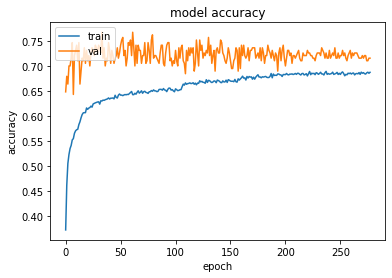

In [ ]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Fine Tune

In [ ]:
#finetune_model_fpath = '/content/drive/MyDrive/PHD/Model/finetune_model.h5'
#mc_finetune = ModelCheckpoint(finetune_model_fpath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
# we chose to train the top 2 resnet blocks, i.e. we will freeze
# the first 49 layers and unfreeze the rest:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
#model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
#hst2 = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))
optimizer_SGD = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy', keras.metrics.AUC(name='prc', curve='PR')])
#hst2 = model.fit(dataaugment.flow(X_train,y_train, batch_size=BATCH_SIZE),
hst2 = model.fit(train_data_batches,
                    epochs = EPOCHS, validation_data = valid_data_batches,
 #                   steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


Epoch 1/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8228 - accuracy: 0.6843

1027/1027 [==============================] - 116s 110ms/step - loss: 0.8228 - accuracy: 0.6843 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 2/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8268 - accuracy: 0.6858

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8268 - accuracy: 0.6858 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 3/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8219 - accuracy: 0.6850

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8219 - accuracy: 0.6850 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 4/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8241 - accuracy: 0.6859

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8241 - accuracy: 0.6859 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 5/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8191 - accuracy: 0.6860

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8191 - accuracy: 0.6860 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 6/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.6849

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8212 - accuracy: 0.6849 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 7/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8239 - accuracy: 0.6860

1027/1027 [==============================] - 113s 110ms/step - loss: 0.8239 - accuracy: 0.6860 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 8/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8234 - accuracy: 0.6856

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8234 - accuracy: 0.6856 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 9/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8283 - accuracy: 0.6822

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8283 - accuracy: 0.6822 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 10/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8232 - accuracy: 0.6853

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8232 - accuracy: 0.6853 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 11/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8259 - accuracy: 0.6853

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8259 - accuracy: 0.6853 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 12/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8203 - accuracy: 0.6845

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8203 - accuracy: 0.6845 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 13/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8210 - accuracy: 0.6862

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8210 - accuracy: 0.6862 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 14/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8221 - accuracy: 0.6853

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8221 - accuracy: 0.6853 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 15/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8246 - accuracy: 0.6824

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8246 - accuracy: 0.6824 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 16/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8235 - accuracy: 0.6866

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8235 - accuracy: 0.6866 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 5.0000e-05
Epoch 17/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8234 - accuracy: 0.6869

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8234 - accuracy: 0.6869 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 5.0000e-05
Epoch 18/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8266 - accuracy: 0.6832

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8266 - accuracy: 0.6832 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 5.0000e-05
Epoch 19/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.6832

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8212 - accuracy: 0.6832 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 5.0000e-05
Epoch 20/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8229 - accuracy: 0.6847

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8229 - accuracy: 0.6847 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 5.0000e-05
Epoch 21/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8215 - accuracy: 0.6880

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8215 - accuracy: 0.6880 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 5.0000e-05
Epoch 22/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8216 - accuracy: 0.6873

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8216 - accuracy: 0.6873 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 5.0000e-05
Epoch 23/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8239 - accuracy: 0.6861

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8239 - accuracy: 0.6861 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 5.0000e-05
Epoch 24/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8246 - accuracy: 0.6855

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8246 - accuracy: 0.6855 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 5.0000e-05
Epoch 25/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8223 - accuracy: 0.6831

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8223 - accuracy: 0.6831 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 5.0000e-05
Epoch 26/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8277 - accuracy: 0.6859

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8277 - accuracy: 0.6859 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 27/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8213 - accuracy: 0.6842

1027/1027 [==============================] - 113s 110ms/step - loss: 0.8213 - accuracy: 0.6842 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 28/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8239 - accuracy: 0.6856

1027/1027 [==============================] - 113s 110ms/step - loss: 0.8239 - accuracy: 0.6856 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 29/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.6856

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8264 - accuracy: 0.6856 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 30/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8241 - accuracy: 0.6861

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8241 - accuracy: 0.6861 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 31/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8211 - accuracy: 0.6857

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8211 - accuracy: 0.6857 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 32/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8167 - accuracy: 0.6897

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8167 - accuracy: 0.6897 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 33/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8255 - accuracy: 0.6834

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8255 - accuracy: 0.6834 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 34/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8241 - accuracy: 0.6841

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8241 - accuracy: 0.6841 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 35/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8248 - accuracy: 0.6851

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8248 - accuracy: 0.6851 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 36/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8222 - accuracy: 0.6853

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8222 - accuracy: 0.6853 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 37/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.6845

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8279 - accuracy: 0.6845 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 38/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8217 - accuracy: 0.6825

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8217 - accuracy: 0.6825 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 39/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8267 - accuracy: 0.6855

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8267 - accuracy: 0.6855 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 40/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8272 - accuracy: 0.6817

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8272 - accuracy: 0.6817 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 41/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8226 - accuracy: 0.6855

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8226 - accuracy: 0.6855 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 42/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8167 - accuracy: 0.6870

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8167 - accuracy: 0.6870 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 2.5000e-05
Epoch 43/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8205 - accuracy: 0.6855

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8205 - accuracy: 0.6855 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.2500e-05
Epoch 44/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8262 - accuracy: 0.6837

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8262 - accuracy: 0.6837 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.2500e-05
Epoch 45/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8236 - accuracy: 0.6841

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8236 - accuracy: 0.6841 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.2500e-05
Epoch 46/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8260 - accuracy: 0.6840

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8260 - accuracy: 0.6840 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.2500e-05
Epoch 47/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8257 - accuracy: 0.6817

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8257 - accuracy: 0.6817 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.2500e-05
Epoch 48/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8198 - accuracy: 0.6842

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8198 - accuracy: 0.6842 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.2500e-05
Epoch 49/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8262 - accuracy: 0.6864

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8262 - accuracy: 0.6864 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.2500e-05
Epoch 50/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8268 - accuracy: 0.6840

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8268 - accuracy: 0.6840 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.2500e-05
Epoch 51/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8207 - accuracy: 0.6870

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8207 - accuracy: 0.6870 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.2500e-05
Epoch 52/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8244 - accuracy: 0.6840

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8244 - accuracy: 0.6840 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.2500e-05
Epoch 53/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8189 - accuracy: 0.6905

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8189 - accuracy: 0.6905 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-05
Epoch 54/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8231 - accuracy: 0.6818

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8231 - accuracy: 0.6818 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-05
Epoch 55/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8232 - accuracy: 0.6839

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8232 - accuracy: 0.6839 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-05
Epoch 56/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8288 - accuracy: 0.6833

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8288 - accuracy: 0.6833 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-05
Epoch 57/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8194 - accuracy: 0.6879

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8194 - accuracy: 0.6879 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-05
Epoch 58/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8287 - accuracy: 0.6827

1027/1027 [==============================] - 113s 110ms/step - loss: 0.8287 - accuracy: 0.6827 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-05
Epoch 59/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8197 - accuracy: 0.6873

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8197 - accuracy: 0.6873 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-05
Epoch 60/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8175 - accuracy: 0.6900

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8175 - accuracy: 0.6900 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-05
Epoch 61/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8235 - accuracy: 0.6888

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8235 - accuracy: 0.6888 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-05
Epoch 62/1000
1027/1027 [==============================] - ETA: 0s - loss: 0.8238 - accuracy: 0.6863

1027/1027 [==============================] - 112s 109ms/step - loss: 0.8238 - accuracy: 0.6863 - val_loss: 0.8183 - val_accuracy: 0.7150 - lr: 1.0000e-05


In [ ]:
# load the saved model
finetune_model = load_model(best_model_fpath)
# evaluate the model
#_, train_acc = finetune_model.evaluate(X_train, y_train, verbose=0)
#_, test_acc = finetune_model.evaluate(X_val, y_val, verbose=0)
#print('Train: %.3f, Val: %.3f' % (train_acc, test_acc))

In [42]:
y_val_pred = finetune_model.predict(X_val)
y_train_pred = finetune_model.predict(X_train)

print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))

balanced accuracy on validation 0.5952252741451348


In [43]:
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))
#print('Score on test data: ',precision_recall_fscore_support(y_test, y_pred2, average='macro'))

Score on val data:  (0.5480594343000358, 0.5952252741451348, 0.4979639157140638, None)


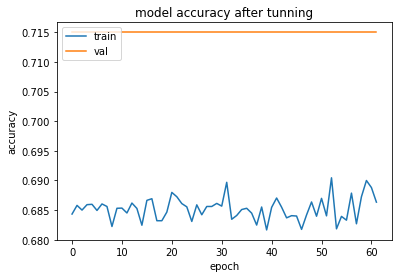

In [44]:
# summarize history for accuracy
plt.plot(hst2.history['accuracy'])
plt.plot(hst2.history['val_accuracy'])
plt.title('model accuracy after tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Testing
Result from ISIC Live
last_model: 0.506
best_model: 0.478

In [45]:
dir_test = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Test_Input/'
filepaths = sorted( filter( lambda x: (os.path.isfile(os.path.join(dir_test, x))) and (x.endswith('.jpg')),
                        os.listdir(dir_test) ) )

In [46]:
df_test = pd.DataFrame(filepaths, columns =['image'])
df_test['FilePaths'] = dir_test + df_test['image']
#df_test

,image,FilePaths
0,ISIC_0034524.jpg,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
1,ISIC_0034525.jpg,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
2,ISIC_0034526.jpg,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
3,ISIC_0034527.jpg,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
4,ISIC_0034528.jpg,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
...,...,...
1507,ISIC_0036060.jpg,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
1508,ISIC_0036061.jpg,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
1509,ISIC_0036062.jpg,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
1510,ISIC_0036063.jpg,/content/drive/MyDrive/PHD/Datasets/isic2018/I...


In [47]:
df_test['image'] = df_test['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

In [48]:
X_test = np.asarray(df_test['image'].tolist())
print(np.array(X_test).shape)

(1512, 224, 224, 3)


Calculate y_pred from training and testing for analysis

In [52]:
# predicted labels
Y_pred2 = model.predict(X_test)
print("Y_pred2", Y_pred2.shape)
# rounded labels
y_pred2 = np.argmax(Y_pred2, axis=1)
print("y_pred2", y_pred2.size)

Y_pred2 (1512, 7)
y_pred2 1512


In [53]:
df_pred = pd.DataFrame(Y_pred2, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
df_pred['image'] = df_test['FilePaths'].map(lambda x: x.replace(dir_test, '').replace('.jpg', ''))
df_pred = df_pred[['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']]

In [54]:
df_pred.set_index("image", inplace = True)
df_pred.to_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/response_SMOTEOversampling_last.csv')

#Confusion Metric on Validation Set

In [58]:
#Get the confusion matrix
cf_matrix = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))

print(cf_matrix)

[[  2   0   3   1   2   0   0]
 [  2   6   1   5   0   1   0]
 [  0   0  13   1   4   4   0]
 [  0   0   0   1   0   0   0]
 [  0   0   4   1  15   1   0]
 [  0   2   4   1   7 108   1]
 [  0   0   0   2   0   0   1]]


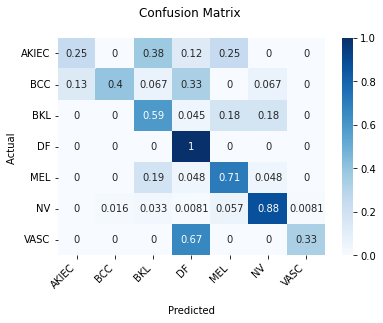

In [59]:
ax = sns.heatmap(cf_matrix / cf_matrix.sum(axis=1, keepdims=True), annot=True, 
            cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
ax.yaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

[Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'DF'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV'),
 Text(0, 0, 'VASC')]

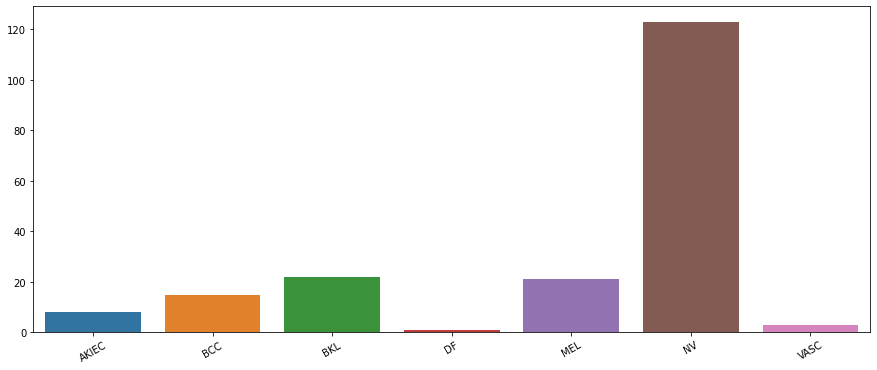

In [60]:
# ordered count of rows per unique label
labels_count = df_val['Labels'].value_counts().sort_index()

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)